# **Atividade Proposta**

Avalie com validação cruzada o desempenho da ELM em um dataset não-artificial.

# **Importações de Bibliotecas e Funções Básicas**

In [88]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.datasets import make_blobs
from sklearn.preprocessing import label_binarize
from sklearn.base import BaseEstimator, ClassifierMixin
from scipy.special import expit

In [89]:
def geradataset(tamanho=20, centros=[[0,0],[1,0],[1,1],[0,1]]):
    X, y = make_blobs(n_samples=tamanho, centers=centros, cluster_std=0.2)
    y = np.array(y%2, dtype=int)
    return X, y

def plotadataset(X, y):
    plt.xlabel('X1')
    plt.ylabel('X2')
    for k in set(y):
        plt.plot(X[:,0][y==k],X[:,1][y==k], "o", alpha=0.3)

def plotahiperplano(vetor, bias=0, xmin=0, xmax=1):
    xs = np.linspace(xmin, xmax, num=2)
    ys = (-vetor[0] / vetor[1]) * xs - bias / vetor[1]
    plt.plot(xs,ys)

# **Funções de Custo**

In [90]:
class CustoPerceptron():
    @staticmethod
    def erro(y, ypred):
        return y - ypred
    @staticmethod
    def custo(y, ypred):
        return np.sum(CustoPerceptron.erro(y, ypred)**2)
    @staticmethod
    def gradiente(y, ypred, X):
        return np.matmul(X.T, CustoPerceptron.erro(y, ypred))

class Adaline():
    def __init__(self):
        self.preactivated = True
    @staticmethod
    def erro(y, ypred):
        return y - ypred
    @staticmethod
    def custo(y, ypred):
        return np.sum((1 - Adaline.erro(y, ypred))**2)
    @staticmethod
    def gradiente(y, ypred, X):
        return np.matmul(X.T, Adaline.erro(y, ypred))

In [91]:
class DescidaGradiente():
    def __init__(self, custo=Adaline(), maxiter=1000, alpha=0.005):
        self.custo = custo
        self.maxiter = maxiter
        self.alpha = alpha
    
    def getW(self, X, y, activation=lambda a: a):
        w = np.random.uniform(-1, -1, size=(X.shape[1], y.shape[1]))
        for _ in range(self.maxiter):
            ypred = activation(np.matmul(X, w))
            custo = self.custo.custo(y, ypred)
            if custo == 0:
                break
            w = w + self.alpha * self.custo.gradiente(y, ypred, X)
        return w

class PseudoInversa():
    def __init__(self):
        pass
    def getW(self, X, y):
        pinv = np.linalg.pinv(X)
        w = np.matmul(pinv, y)
        return w

# **Implementação do ELM**

In [92]:
def tanh(a):
    return expit(a) * 2 - 1

class ExtremeLearningMachine(BaseEstimator, ClassifierMixin):
    def __init__(self, algoritmo=PseudoInversa()):
        self.wih = None
        self.w = None
        self.threshold = 0
        self.activation = tanh
        self.algoritmo = algoritmo
    
    @staticmethod
    def includebias(X):
        bias = np.ones((X.shape[0],1))
        Xb = np.concatenate((bias,X), axis=1)
        return Xb
    
    def fit(self, X, y):
        self.wih = np.random.uniform(-1, 1, size=(X.shape[1],X.shape[0]//3))
        Xh = np.matmul(X, self.wih)
        Xho = self.activation(Xh)
        X = ExtremeLearningMachine.includebias(Xho)
        self.labels = list(set(y))
        y = label_binarize(y, classes=self.labels)*2-1
        if len(self.labels) == 2 :
            y = y[:,0:1]
        # treinamento
        if hasattr(self.algoritmo, 'custo') and not (hasattr(self.algoritmo.custo, 'preactivated') and self.algoritmo.custo.preactivated):
            self.w = self.algoritmo.getW(X, y, self.activation)
        else:
            self.w = self.algoritmo.getW(X, y)

    def predict(self, X):
        Xh = np.matmul(X, self.wih)
        Xho = self.activation(Xh)
        Xb = ExtremeLearningMachine.includebias(Xho)
        a = np.matmul(Xb, self.w)
        if self.w.shape[1] > 1:
            idx = np.argmax(a, axis=1) 
        else:
            idx = np.array(self.activation(a) > self.threshold, dtype=int)[:,0]
        ypred = np.array([self.labels[i] for i in idx])
        return ypred

# **Testes e Demais atividades**

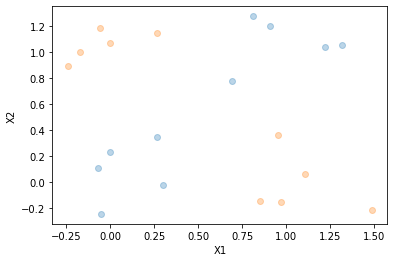

(array([[ 2.68293492e-01,  3.49266360e-01],
        [-5.64193555e-02,  1.18300583e+00],
        [ 8.14292932e-01,  1.27489267e+00],
        [ 1.48988112e+00, -2.18583293e-01],
        [ 3.40823887e-04,  2.30569403e-01],
        [ 2.98052010e-01, -2.13341911e-02],
        [ 9.54492715e-01,  3.59506652e-01],
        [ 1.32164071e+00,  1.05316531e+00],
        [ 9.11308124e-01,  1.20248743e+00],
        [-1.71038061e-01,  9.98339689e-01],
        [ 6.93284347e-01,  7.73802364e-01],
        [-5.22773225e-02, -2.46493307e-01],
        [-6.88377462e-02,  1.07913323e-01],
        [-2.42080612e-01,  8.89540563e-01],
        [-4.43186871e-04,  1.07233865e+00],
        [ 8.53525631e-01, -1.50784719e-01],
        [ 1.22029319e+00,  1.03819894e+00],
        [ 1.11025605e+00,  5.72493296e-02],
        [ 9.69844957e-01, -1.52900939e-01],
        [ 2.66818108e-01,  1.14580179e+00]]),
 array([0, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1]))

In [93]:
X, y = geradataset()
plotadataset(X, y)
plt.show()
X,y

In [94]:
elm = ExtremeLearningMachine()
elm.fit(X, y)

In [95]:
ypred = elm.predict(X)
print(sum(y == ypred)/len(y))

1.0


In [96]:
# Teste com amostras fora do treinamento
Xte, yte = geradataset(10000)
ypred = elm.predict(Xte)
print(sum(yte == ypred)/len(yte))

0.8852


# **Validação Cruzada**

Avalie com validação cruzada o desempenho da ELM em um dataset não-artificial.

Data set não artificial encontrado no link:
https://www.kaggle.com/sulianova/cardiovascular-disease-dataset

coloquei ele no meu github : https://github.com/lopeslopesedu/202101_NeuralNetworks/blob/main/cardio_train.csv

Number of times pregnant.
Plasma glucose concentration a 2 hours in an oral glucose tolerance test.
Diastolic blood pressure (mm Hg).
Triceps skinfold thickness (mm).
2-Hour serum insulin (mu U/ml).
Body mass index (weight in kg/(height in m)^2).
Diabetes pedigree function.
Age (years).
Class variable (0 or 1).

In [97]:
data = pd.read_csv("https://raw.githubusercontent.com/jbrownlee/Datasets/master/pima-indians-diabetes.csv",sep =",")

In [98]:
data

,6,148,72,35,0,33.6,0.627,50,1
0,1,85,66,29,0,26.6,0.351,31,0
1,8,183,64,0,0,23.3,0.672,32,1
2,1,89,66,23,94,28.1,0.167,21,0
3,0,137,40,35,168,43.1,2.288,33,1
4,5,116,74,0,0,25.6,0.201,30,0
...,...,...,...,...,...,...,...,...,...
762,10,101,76,48,180,32.9,0.171,63,0
763,2,122,70,27,0,36.8,0.340,27,0
764,5,121,72,23,112,26.2,0.245,30,0
765,1,126,60,0,0,30.1,0.349,47,1


In [99]:
npdata = data.to_numpy()

In [100]:
#.tolist()
ydata = npdata[:,-1:]
Xdata = npdata[:,1:3]

In [101]:
target = np.zeros(ydata.size)
for i in range(len(ydata)):
  target[i] = ydata[i]
target.shape

(767,)

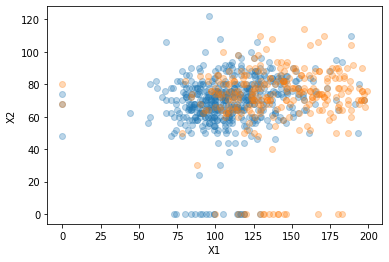

In [102]:
plotadataset(Xdata, target)
plt.show()

In [103]:
elm = ExtremeLearningMachine()
elm.fit(Xdata, target)

In [104]:
ypred = elm.predict(Xdata)
print(sum(target == ypred)/len(target))

0.788787483702738


In [105]:
from sklearn.model_selection import cross_val_score # Cross Validation Function.
from sklearn.model_selection import KFold # KFold Class.

In [106]:
model  = ExtremeLearningMachine()
kfold  = KFold(n_splits=5, shuffle=True) # shuffle=True, Shuffle (embaralhar) the data.
result = cross_val_score(model, Xdata, target, cv = kfold)

print("K-Fold (R^2) Scores: {0}".format(result))
print("Mean R^2 for Cross-Validation K-Fold: {0}".format(result.mean()))

K-Fold (R^2) Scores: [0.72727273 0.73376623 0.66666667 0.71895425 0.7124183 ]
Mean R^2 for Cross-Validation K-Fold: 0.7118156353450471


In [109]:
target = target.astype(int)

/usr/local/lib/python3.7/dist-packages/mlxtend/plotting/decision_regions.py:244: MatplotlibDeprecationWarning: Passing unsupported keyword arguments to axis() will raise a TypeError in 3.3.
  ax.axis(xmin=xx.min(), xmax=xx.max(), y_min=yy.min(), y_max=yy.max())


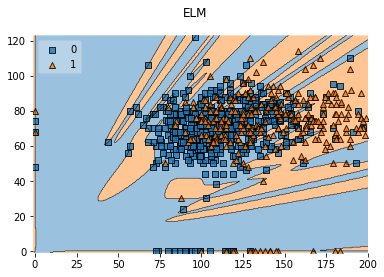

In [111]:
from mlxtend.plotting import plot_decision_regions
import matplotlib.pyplot as plt

fig, ax = plt.subplots()
value = 1.5
width = 0.75
plot_decision_regions(Xdata, target, clf=elm,
                      filler_feature_values={2: value},
                      filler_feature_ranges={2: width},
                      legend=2, ax=ax)

fig.suptitle('ELM')
plt.show()